The task is to predict survival on board of the Titanic:
 
https://www.kaggle.com/c/titanic/
 
The key column is the Age, which has some missing values, so you will need some imputation strategy.
 
Scoring for this assignment goes as follows:

1 point for the preliminary data analysis (proper data reading, basic statistics, visualization)

2 points for feature engineering (imputation of missing values in the Age column, creation of new features)

1 point for the machine learning process (algorithm selection, final test score)

Rules:

Datasets train.csv and test.csv from https://www.kaggle.com/c/titanic/data must be used, no other sources
You cannot use machine learning algorithms for the feature engineering part, only manual techniques. This rules out KNN for imputation, Deep Learning, sklearn.preprocessing.Imputer, fancyimpute, missingno, and similar
The format of the delivery *must*:
be a Jupyter notebook
whose name should contain the surnames of the students in the group
run, top to bottom, without errors on a capable computer with Python 3.6
If you don't manage to get it working, document what approaches did you try, and explain the errors. Do not deliver an unfinished notebook without explanations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
# Set the default visualisation to seaborn layout
sns.set()

In [2]:
train=pd.read_csv('data/all/train.csv',index_col='PassengerId', dtype = {'Pclass': 'category'})

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test=pd.read_csv('data/all/test.csv',index_col='PassengerId', dtype = {'Pclass': 'category'})

In [5]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null category
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 77.5+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null category
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null obj

In [7]:
train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Kelly, Mr. James",male,1601,B96 B98,S
freq,1,577,7,4,644


Names are unique across the dataset (count=unique=891)
Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
Embarked takes three possible values. S port used by most passengers (top=S)
Ticket feature has high ratio (22%) of duplicate values (unique=681).


Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

In [9]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Visualize data importance with Survival

Age

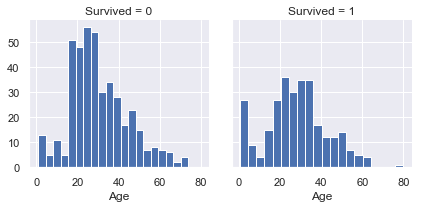

In [13]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Pclass

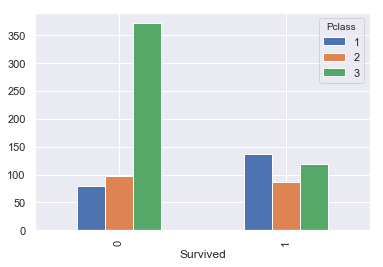

In [14]:
my_tab = pd.crosstab(index = train["Survived"],  
                              columns=train['Pclass'])      

my_tab.plot.bar()

Sex

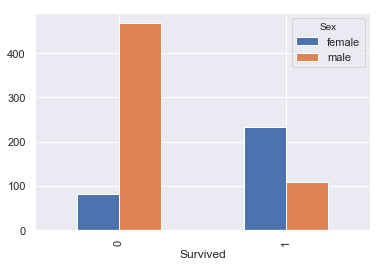

In [15]:
pd.crosstab(index = train["Survived"],  columns=train['Sex']).plot.bar() 

In [16]:
#Age 	SibSp 	Parch 	Ticket 	Fare 	Cabin 	Embarked

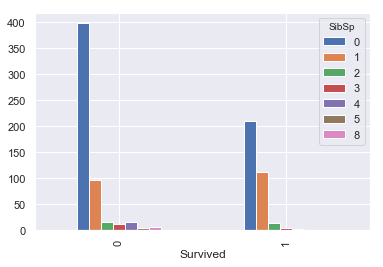

In [17]:
pd.crosstab(index = train["Survived"],  columns=train['SibSp']).plot.bar() 

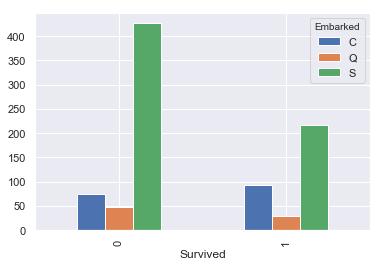

In [18]:
pd.crosstab(index = train["Survived"],  columns=train['Embarked']).plot.bar() 

2 points for feature engineering (imputation of missing values in the Age column, creation of new features)

In [47]:
titanic = pd.concat([train, test])
titanic['Pclass'] = titanic['Pclass'].astype('category')
titanic.head()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


Drop Cabin column, we have many missing values.

In [48]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [49]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null category
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: category(1), float64(3), int64(2), object(5)
memory usage: 113.9+ KB


In [50]:
def clas(row):
    if row['Age'] < 8:
        return 'childhood'
    elif row['Age'] >= 8 and row['Age'] < 11:
        return 'Child'
    elif row['Age'] >= 11 and row['Age'] < 18:
        return 'Adolescence'
    elif row['Age'] >= 18 and row['Age'] < 26:
        return 'youth'
    elif row['Age'] >= 26 and row['Age'] < 60:
        return 'mature'
    else:
        return 'eldery'

titanic["Group_Age"] = titanic.apply(clas, axis=1)

In [51]:
titanic['Title'] = titanic.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
a=pd.crosstab(titanic['Group_Age'], titanic['Title'])
a.head()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Group_Age,,,,,,,,,,,,,,,,,,
Adolescence,0,0,0,0,0,0,0,0,0,8,26,0,0,29,5,0,0,0
Child,0,0,0,0,0,0,0,0,0,10,10,0,0,0,0,0,0,0
childhood,0,0,0,0,0,0,0,0,0,35,31,0,0,0,0,0,0,0
eldery,1,1,0,0,0,1,0,0,0,8,51,0,0,203,37,1,0,0
mature,0,3,1,1,1,6,1,1,2,0,71,0,0,343,123,1,8,1


Ahora nan values le damos una edad media dependiendo del grupo de edad en el q este segun el titulo q tengan

In [53]:
titanic.loc[titanic['Age'].isnull()]['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Ms'], dtype=object)

In [54]:
outliers = titanic[titanic['Fare'] > titanic['Fare'].std()*3 + titanic['Fare'].mean()]
'There are {} outliers in the Fare columns'.format(outliers.shape[0])

'There are 38 outliers in the Fare columns'

In [55]:
titanic.loc[outliers.index, 'Fare'] = None

In [56]:
titanic['Fare'] = titanic.groupby(['Pclass'])['Fare']\
    .transform(lambda x: x.fillna(x.mean()))

In [57]:
titanic

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Group_Age,Title
PassengerId,,,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,youth,Mr
2,38.0,C85,C,71.283300,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,mature,Mrs
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,mature,Miss
4,35.0,C123,S,53.100000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,mature,Mrs
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,mature,Mr
6,NaN,NaN,Q,8.458300,"Moran, Mr. James",0,3,male,0,0.0,330877,eldery,Mr
7,54.0,E46,S,51.862500,"McCarthy, Mr. Timothy J",0,1,male,0,0.0,17463,mature,Mr
8,2.0,NaN,S,21.075000,"Palsson, Master. Gosta Leonard",1,3,male,3,0.0,349909,childhood,Master
9,27.0,NaN,S,11.133300,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1.0,347742,mature,Mrs


In [58]:
titanic['Has_cabin'] = ~titanic['Cabin'].isnull()

In [59]:
titanic['Age'] = titanic.groupby(['Pclass', 'Title'])['Age']\
    .transform(lambda x: x.fillna(x.mean()))

In [60]:
titanic=titanic.drop('Cabin',axis=1)

In [61]:
titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1

In [62]:
titanic['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [63]:
titanic.count()

Age            1308
Embarked       1307
Fare           1309
Name           1309
Parch          1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
Group_Age      1309
Title          1309
Has_cabin      1309
Family_size    1309
dtype: int64

In [64]:
titanic.loc[titanic['Embarked'].isnull(), 'Embarked'] = 'C'

In [65]:
titanic['Age']=titanic['Age'].fillna(2.3)

In [66]:
titanic.count()

Age            1309
Embarked       1309
Fare           1309
Name           1309
Parch          1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
Group_Age      1309
Title          1309
Has_cabin      1309
Family_size    1309
dtype: int64

In [67]:
titanic['Age_cat'] = pd.cut(titanic['Age'], 10, labels=False)

In [68]:
titanic

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Group_Age,Title,Has_cabin,Family_size,Age_cat
PassengerId,,,,,,,,,,,,,,,
1,22.000000,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,youth,Mr,False,2,2
2,38.000000,C,71.283300,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,mature,Mrs,True,2,4
3,26.000000,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,mature,Miss,False,1,3
4,35.000000,S,53.100000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,mature,Mrs,True,2,4
5,35.000000,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,mature,Mr,False,1,4
6,28.318910,Q,8.458300,"Moran, Mr. James",0,3,male,0,0.0,330877,eldery,Mr,False,1,3
7,54.000000,S,51.862500,"McCarthy, Mr. Timothy J",0,1,male,0,0.0,17463,mature,Mr,True,1,6
8,2.000000,S,21.075000,"Palsson, Master. Gosta Leonard",1,3,male,3,0.0,349909,childhood,Master,False,5,0
9,27.000000,S,11.133300,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1.0,347742,mature,Mrs,False,3,3


In [69]:
titanic['Title'] = titanic['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})

In [70]:
titanic['Fare_cat'] = pd.cut(titanic['Fare'], 10, precision=0, labels=False)

In [71]:
titanic.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Group_Age,Title,Has_cabin,Family_size,Age_cat,Fare_cat
PassengerId,,,,,,,,,,,,,,,,
1,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,youth,Mr,False,2,2,0
2,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,mature,Mrs,True,2,4,4
3,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,mature,Miss,False,1,3,0
4,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,mature,Mrs,True,2,4,3
5,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,mature,Mr,False,1,4,0


In [ ]:
#add one variable more and see what variables are more used for the model and so on

In [75]:
titanic['IsAlone'] = 0
titanic.loc[titanic['Family_size'] == 1, 'IsAlone'] = 1

#titanic[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [76]:
titanic[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [80]:
titanic.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Group_Age,Title,Has_cabin,Family_size,Age_cat,Fare_cat,IsAlone
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,youth,Mr,False,2,2,0,0
2,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,mature,Mrs,True,2,4,4,0
3,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,mature,Miss,False,1,3,0,1
4,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,mature,Mrs,True,2,4,3,0
5,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,mature,Mr,False,1,4,0,1


In [82]:
titanic.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Group_Age,Title,Has_cabin,Family_size,Age_cat,Fare_cat,IsAlone
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,youth,Mr,False,2,2,0,0
2,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,mature,Mrs,True,2,4,4,0
3,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,mature,Miss,False,1,3,0,1
4,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,mature,Mrs,True,2,4,3,0
5,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,mature,Mr,False,1,4,0,1


In [84]:
titanic = titanic.drop(['Name', 'Ticket', 'Age', 'Fare','Group_Age'], axis=1)

In [85]:
titanic.head()

,Embarked,Parch,Pclass,Sex,SibSp,Survived,Title,Has_cabin,Family_size,Age_cat,Fare_cat,IsAlone
PassengerId,,,,,,,,,,,,
1,S,0,3,male,1,0.0,Mr,False,2,2,0,0
2,C,0,1,female,1,1.0,Mrs,True,2,4,4,0
3,S,0,3,female,0,1.0,Miss,False,1,3,0,1
4,S,0,1,female,1,1.0,Mrs,True,2,4,3,0
5,S,0,3,male,0,0.0,Mr,False,1,4,0,1


In [86]:
titanic_dum = pd.get_dummies(titanic)
titanic_dum.head()

,Parch,SibSp,Survived,Has_cabin,Family_size,Age_cat,Fare_cat,IsAlone,Embarked_C,Embarked_Q,...,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0.0,False,2,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1.0,True,2,4,4,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1.0,False,1,3,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,1.0,True,2,4,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0.0,False,1,4,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [87]:
titanic_dum.columns

Index(['Parch', 'SibSp', 'Survived', 'Has_cabin', 'Family_size', 'Age_cat',
       'Fare_cat', 'IsAlone', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Title_Capt', 'Title_Col', 'Title_Countess', 'Title_Don', 'Title_Dona',
       'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
       'Title_Sir'],
      dtype='object')

In [88]:
titanic_dum.count()

Parch             1309
SibSp             1309
Survived           891
Has_cabin         1309
Family_size       1309
Age_cat           1309
Fare_cat          1309
IsAlone           1309
Embarked_C        1309
Embarked_Q        1309
Embarked_S        1309
Pclass_1          1309
Pclass_2          1309
Pclass_3          1309
Sex_female        1309
Sex_male          1309
Title_Capt        1309
Title_Col         1309
Title_Countess    1309
Title_Don         1309
Title_Dona        1309
Title_Dr          1309
Title_Jonkheer    1309
Title_Lady        1309
Title_Major       1309
Title_Master      1309
Title_Miss        1309
Title_Mr          1309
Title_Mrs         1309
Title_Rev         1309
Title_Sir         1309
dtype: int64

In [125]:
#https://www.kaggle.com/startupsci/titanic-data-science-solutions

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

    Logistic Regression
    KNN or k-Nearest Neighbors
    Support Vector Machines
    Naive Bayes classifier
    Decision Tree
    Random Forrest
    Perceptron
    Artificial neural network
    RVM or Relevance Vector Machine


In [89]:
titanic_dum=titanic_dum.loc[:891]

In [90]:
titanic_dum.count()

Parch             891
SibSp             891
Survived          891
Has_cabin         891
Family_size       891
Age_cat           891
Fare_cat          891
IsAlone           891
Embarked_C        891
Embarked_Q        891
Embarked_S        891
Pclass_1          891
Pclass_2          891
Pclass_3          891
Sex_female        891
Sex_male          891
Title_Capt        891
Title_Col         891
Title_Countess    891
Title_Don         891
Title_Dona        891
Title_Dr          891
Title_Jonkheer    891
Title_Lady        891
Title_Major       891
Title_Master      891
Title_Miss        891
Title_Mr          891
Title_Mrs         891
Title_Rev         891
Title_Sir         891
dtype: int64

In [91]:
from sklearn.model_selection import train_test_split
X = titanic_dum[titanic_dum.columns[titanic_dum.columns.values != 'Survived']].values
y = titanic_dum['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference Wikipedia.

Note the confidence score generated by the model based on our training dataset.

In [93]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [96]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

C:\Users\david\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


83.89

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

    Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of   Survived=1 increases the most.
    Inversely as Pclass increases, probability of Survived=1 decreases the most.
    This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
    So is Title as second highest positive correlation.


In [97]:
coeff_df = pd.DataFrame(titanic_dum.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
24,Title_Master,2.106903
13,Sex_female,1.176936
27,Title_Mrs,0.926647
10,Pclass_1,0.825145
2,Has_cabin,0.627766
7,Embarked_C,0.336963
11,Pclass_2,0.241483
8,Embarked_Q,0.232765
5,Fare_cat,0.209716
22,Title_Lady,0.111906


In [98]:
titanic_dum=titanic_dum.drop(['Title_Sir','Title_Dona'],axis=1)

In [100]:
from sklearn.svm import SVC
from sklearn.metrics import scorer

In [101]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

C:\Users\david\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


84.4

In [113]:
'The logistic regression classified {:0.0%} of the values correct'.format(accuracy_score(y_test, Y_pred))


'The logistic regression classified 81% of the values correct'

In [114]:
from sklearn.neighbors import KNeighborsClassifier

In [115]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn


78.86

In [116]:
'The logistic regression classified {:0.0%} of the values correct'.format(accuracy_score(y_test, Y_pred))


'The logistic regression classified 73% of the values correct'

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [119]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

91.44

In [120]:
'The logistic regression classified {:0.0%} of the values correct'.format(accuracy_score(y_test, Y_pred))


'The logistic regression classified 82% of the values correct'

In [121]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree



91.44

In [122]:
'The logistic regression classified {:0.0%} of the values correct'.format(accuracy_score(y_test, Y_pred))


'The logistic regression classified 81% of the values correct'

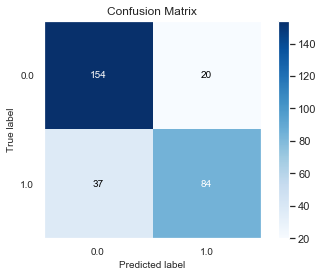

In [123]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=Y_pred);

In [124]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN',
              'Random Forest',
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, 
              acc_random_forest,acc_decision_tree]})
models.sort_values(by='Score', ascending=False)



,Model,Score
2,Random Forest,91.44
3,Decision Tree,91.44
0,Support Vector Machines,84.40
1,KNN,78.86
